In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Prepare data
policy = pd.read_excel('/Users/Jenny/Desktop/COVID19/cleaned/COVID-19 US state policy database 6_10_2020.xlsx', skiprows = range(1, 5))
mobility = pd.read_csv('/Users/Jenny/Desktop/COVID19/cleaned/covid19_us_summary.csv')
# Fix NV's FM_ALL
policy.loc[policy['POSTCODE']=='NV', 'FM_ALL'] = 0
policy.head(3)

,STATE,POSTCODE,STEMERG,CLSCHOOL,CLDAYCR,CLNURSHM,STAYHOME,END_STHM,CLBSNS,END_BSNS,...,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18
0,Alabama,AL,2020-03-13,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-19 00:00:00,2020-04-04 00:00:00,2020-04-30 00:00:00,2020-03-28 00:00:00,2020-04-30 00:00:00,...,0,0,93.24,4887871,52420.0,3261,5.6,16.8,43.1,54352
1,Alaska,AK,2020-03-11,2020-03-16 00:00:00,0,0,2020-03-28 00:00:00,2020-04-24 00:00:00,2020-03-28 00:00:00,2020-04-24 00:00:00,...,0,1,1.11,737438,665384.0,1907,6.8,10.9,32.8,4453
2,Arizona,AZ,2020-03-11,2020-03-16 00:00:00,0,0,2020-03-31 00:00:00,2020-05-16 00:00:00,2020-03-30 00:00:00,2020-05-08 00:00:00,...,1,1,62.91,7171646,113990.0,10007,5.4,14.0,39.1,59282


In [3]:
mobility['a_date'] = pd.to_datetime(mobility['a_date'])
mobility.head(3)

,a_state,a_date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,b_state,b_date,confirmed_cases_state,deaths_state
0,AL,2020-02-15,5,2,39.0,7,2,-1,AL,2020-02-15,0,0
1,AL,2020-02-16,0,-2,-7.0,3,-1,1,AL,2020-02-16,0,0
2,AL,2020-02-17,3,0,17.0,7,-17,4,AL,2020-02-17,0,0


In [4]:
policy.columns

Index(['STATE', 'POSTCODE', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'CLNURSHM',
       'STAYHOME', 'END_STHM', 'CLBSNS', 'END_BSNS', 'RELIGEX', 'FM_ALL',
       'FM_EMP', 'ALCOPEN', 'GUNOPEN', 'CLREST', 'ENDREST', 'RSTOUTDR',
       'CLGYM', 'ENDGYM', 'CLMOVIE', 'END_MOV', 'EVICINTN', 'EVICENF', 'RNTGP',
       'UTILSO', 'MORGFR', 'SNAPALLO', 'SNAPEBT', 'SNAPSUSP', 'MED1135W',
       'ACAENROL', 'PREVTLHL', 'TLHLAUD', 'TLHLMED', 'RACETEST', 'RACECASE',
       'RACEHOSP', 'RACEDEAT', 'ELECPRCR', 'ENDELECP', 'WTPRD', 'WV_WTPRD',
       'WV_WKSR', 'UIQUAR', 'UICLDCR', 'UIEXTND', 'UIMAXAMT', 'UIMAXEXT',
       'UIMAXDUR', 'UIMAXCAR', 'LMABRN', 'TLHlBUPR', 'EXTOPFL', 'HMDLVOP',
       'TLHLCL24', 'EXCEMORP', 'WVDEAREQ', 'PDSKLV', 'MEDEXP', 'POPDEN18',
       'POP18', 'SQML', 'HMLS19', 'UNEMP18', 'POV18', 'RISKCOV', 'DEATH18'],
      dtype='object')

# Data Prep
#close: 'CLNURSHM', 'EVICINTN', 'EVICENF'
a = ['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'STAYHOME', 'CLBSNS', 'FM_ALL', 'FM_EMP', 'CLREST', 'CLGYM', 'CLMOVIE']

#reopen: 'END_MOV'
b = ['END_STHM', 'END_BSNS', 'ENDREST', 'ENDGYM']


one time
['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'FM_ALL', 'FM_EMP', 'CLNURSHM', 'EVICINTN', 'EVICENF']

start-end pair
['STAYHOME', 'CLBSNS','CLREST', 'CLGYM', 'CLMOVIE', 'END_STHM', 'END_BSNS', 'ENDREST', 'ENDGYM', 'END_MOV']

In [4]:
onetime = ['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'FM_ALL', 'FM_EMP', 'CLNURSHM', 'EVICINTN', 'EVICENF']
pair = [('STAYHOME','END_STHM'), ('CLBSNS','END_BSNS'), ('CLREST','ENDREST'),
        ('CLGYM','ENDGYM'), ('CLMOVIE','END_MOV')]

In [5]:
def onetimePolicy_dummy(mobility_df, policy_df, policy_list):
    """
    policy_list: a list of policy names
    mobility_df: mobility dataset
    policy_df: policy dataset
    """

    df = policy_df[['POSTCODE']+policy_list]
    df = df.replace(0, datetime.datetime(2020,12,31))
    output = mobility_df.merge(df, how='left', left_on='a_state', right_on='POSTCODE')
    for policy in policy_list:
        output[policy] = (output[policy] <= output['a_date'])*1
        
    return output

data = onetimePolicy_dummy(mobility, policy, onetime)

In [6]:
def startendPolicy_dummy(mobility_df, policy_df, policy_list):
    """
    policy_list: a list of policy names, should be in thie format [(start, end), (start, end)]
    mobility_df: mobility dataset
    policy_df: policy dataset
    """
    
    from itertools import chain
    policy_list_flattened = list(chain.from_iterable(policy_list))
    df = policy_df[['POSTCODE'] + policy_list_flattened]
    df = df.replace(0, datetime.datetime(2020,12,31))
    
    output = mobility_df.merge(df, how='left', left_on='a_state', right_on='POSTCODE')
    for start, end in policy_list:
        output[start] = (output[start] <= output['a_date'])*1
        output[start] = np.where(output[end] > output['a_date'], output[start], 0)
        output[end] = (output[end] <= output['a_date'])*1
    
    return output
    
data = startendPolicy_dummy(data, policy, pair)

In [7]:
data.columns

Index(['a_state', 'a_date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit_stations', 'workplaces', 'residential', 'b_state',
       'b_date', 'confirmed_cases_state', 'deaths_state', 'POSTCODE_x',
       'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'FM_ALL', 'FM_EMP', 'CLNURSHM',
       'EVICINTN', 'EVICENF', 'POSTCODE_y', 'STAYHOME', 'END_STHM', 'CLBSNS',
       'END_BSNS', 'CLREST', 'ENDREST', 'CLGYM', 'ENDGYM', 'CLMOVIE',
       'END_MOV'],
      dtype='object')

In [58]:
data.to_csv('policy_mobiliy.csv', index=False)

In [39]:
# data = pd.read_csv('/Users/Jenny/Desktop/COVID19/cleaned/policy_mobiliy.csv')
# data.head()
data.a_date = pd.to_datetime(data.a_date)

# EDA
Distribution of Y

In [10]:
Y = ['retail_and_recreation', 'grocery_and_pharmacy', 'transit_stations', 'workplaces', 'residential']
data[Y].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5814 entries, 0 to 5813
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   retail_and_recreation  5814 non-null   int64
 1   grocery_and_pharmacy   5814 non-null   int64
 2   transit_stations       5814 non-null   int64
 3   workplaces             5814 non-null   int64
 4   residential            5814 non-null   int64
dtypes: int64(5)
memory usage: 272.5 KB


retail_and_recreation


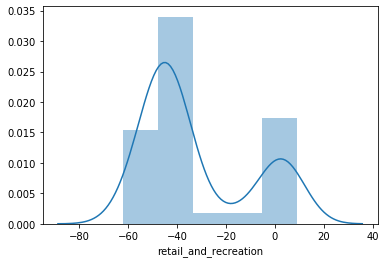

grocery_and_pharmacy


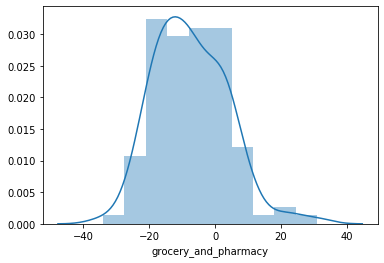

transit_stations


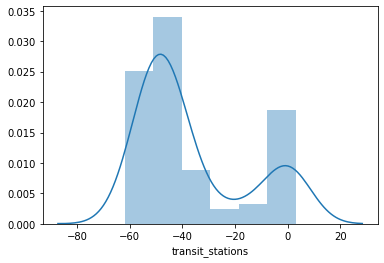

workplaces


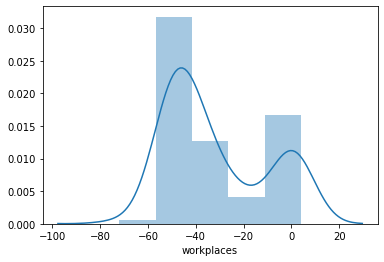

residential


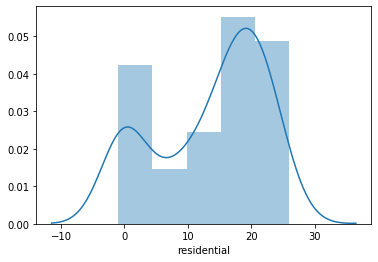

retail_and_recreation


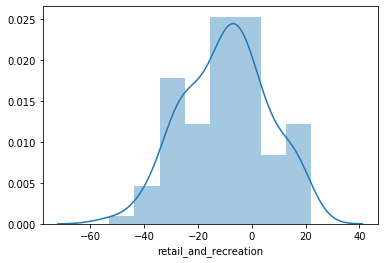

grocery_and_pharmacy


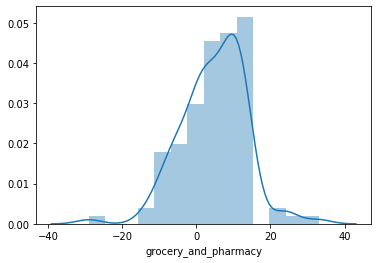

transit_stations


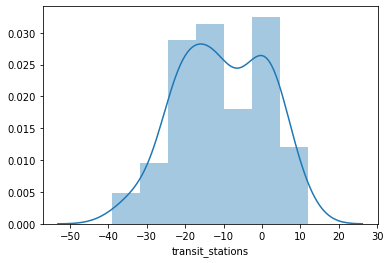

workplaces


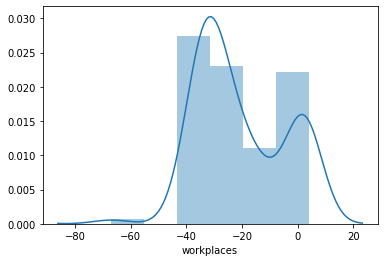

residential


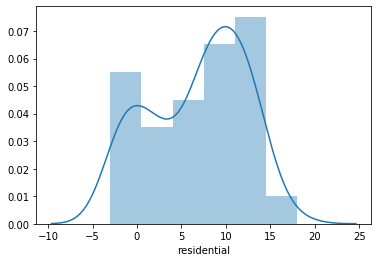

In [83]:
for state in ['CA', 'AR']:
    for y in Y:
        print(y)
        sns.distplot(data.loc[data['a_state']==state, y])
        plt.show()

# Baseline model
Linear regression model

In [8]:
from itertools import chain
pair_flattened = list(chain.from_iterable(pair))
cols = ['retail_and_recreation'] + onetime + pair_flattened

In [ ]:
# model_df = data.loc[data['a_state']=='IL', cols]
# model_df['y_diff'] = model_df['retail_and_recreation'].diff()
# model_df = model_df.dropna()
# model_df = model_df.reset_index(drop=True)     

# # IL
# import statsmodels.api as sm
# X = sm.add_constant(model_df[onetime + pair_flattened])
# mod = sm.OLS(model_df['retail_and_recreation'], X)

# result = mod.fit()
# print(result.summary())

# Model suffers from high multicollinearity. 



# sns.distplot(model_df['y_diff'])

# Bayesian Approach 
Predictors: 
- policies
- weekend indicator
- log of new cases

Prediction: leave 7 days

In [9]:
import pystan
import arviz as az

In [40]:
data['weekno'] = data['a_date'].apply(lambda x: x.weekday())
data['sat'] = np.where(data['weekno']==5, 1, 0)
data['sun'] = np.where(data['weekno']==6, 1, 0)

In [41]:
# train-test split
def model_data(df, X, y, state):
    df = df[df['a_state']==state]
    df = df[X+y]
    df = df.reset_index(drop=True)
    
    return df

def train_test_split(df, days):
    train = df.loc[:df.shape[0]-(days+1)]
    test = df.loc[df.shape[0]-days:]
    
    return train, test

In [69]:
def new_confirmed_log_shifted(mobility):
    new = mobility['confirmed_cases_state'].diff()
    new = np.log(new).replace(-np.inf,0)
    new = new.fillna(0)
    mobility['new_confirmed_log'] = new
    mobility['new_confirmed_log'] = mobility['new_confirmed_log'].shift(7)
    mobility['new_confirmed_log'] = mobility['new_confirmed_log'].fillna(0)
    mobility = mobility.drop('confirmed_cases_state', axis=1)
    return mobility


In [70]:
def data_list(train, test, target):
    x = train.drop(target, axis=1)
    y = train[target]
    N = x.shape[0]
    Nx = x.shape[1]
    N_tilda = test.shape[0]
    x_tilda = test.drop(target, axis=1)
    
    datalist = {'N': N,
               'Nx': Nx,
               'y': y,
               'x': x,
               'N_tilda': N_tilda, 
               'x_tilda': x_tilda}
    
    return datalist

In [71]:
exog = onetime + pair_flattened+['confirmed_cases_state', 'sat', 'sun']
endog = ['retail_and_recreation']
model_df2 = model_data(data, X=exog, y=endog, state='IL')
model_df2 = new_confirmed_log_shifted(model_df2)
model_df2[onetime + pair_flattened] = model_df2[onetime + pair_flattened].cumsum()

train, test = train_test_split(model_df2, 7)

In [80]:
train.columns

Index(['STEMERG', 'CLSCHOOL', 'CLDAYCR', 'FM_ALL', 'FM_EMP', 'CLNURSHM',
       'EVICINTN', 'EVICENF', 'STAYHOME', 'END_STHM', 'CLBSNS', 'END_BSNS',
       'CLREST', 'ENDREST', 'CLGYM', 'ENDGYM', 'CLMOVIE', 'END_MOV', 'sat',
       'sun', 'retail_and_recreation', 'new_confirmed_log'],
      dtype='object')

In [73]:
modelscript2 = """
data {
    int<lower=0> N;
    int<lower=0> Nx;
    real y[N];
    matrix[N, Nx] x;
    int<lower=0> N_tilda;
    matrix[N_tilda, Nx] x_tilda;
}
parameters {
    real beta0;
    vector[Nx] beta;
    real<lower=0> sigma;
}
model {
    beta0 ~ cauchy(0,10);
    sigma ~ cauchy(0,5);
    
    for (i in 1:Nx)
        beta[i] ~ normal(0,5);
    
    y ~ normal(beta0 + x*beta, sigma);
}
generated quantities {
    real y_tilda[N_tilda] 
        = normal_rng(beta0 + x_tilda*beta, sigma);
}
"""

datalist = data_list(train, test, 'retail_and_recreation')

In [74]:
prediction2 = pystan.stan(model_code=modelscript2, data=datalist, 
                                         iter=1000, chains=2, control={'max_treedepth': 15}, seed=9)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f720581808657b0f4c6cdb28888475d2 NOW.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a280d9048>,
      dtype=object)

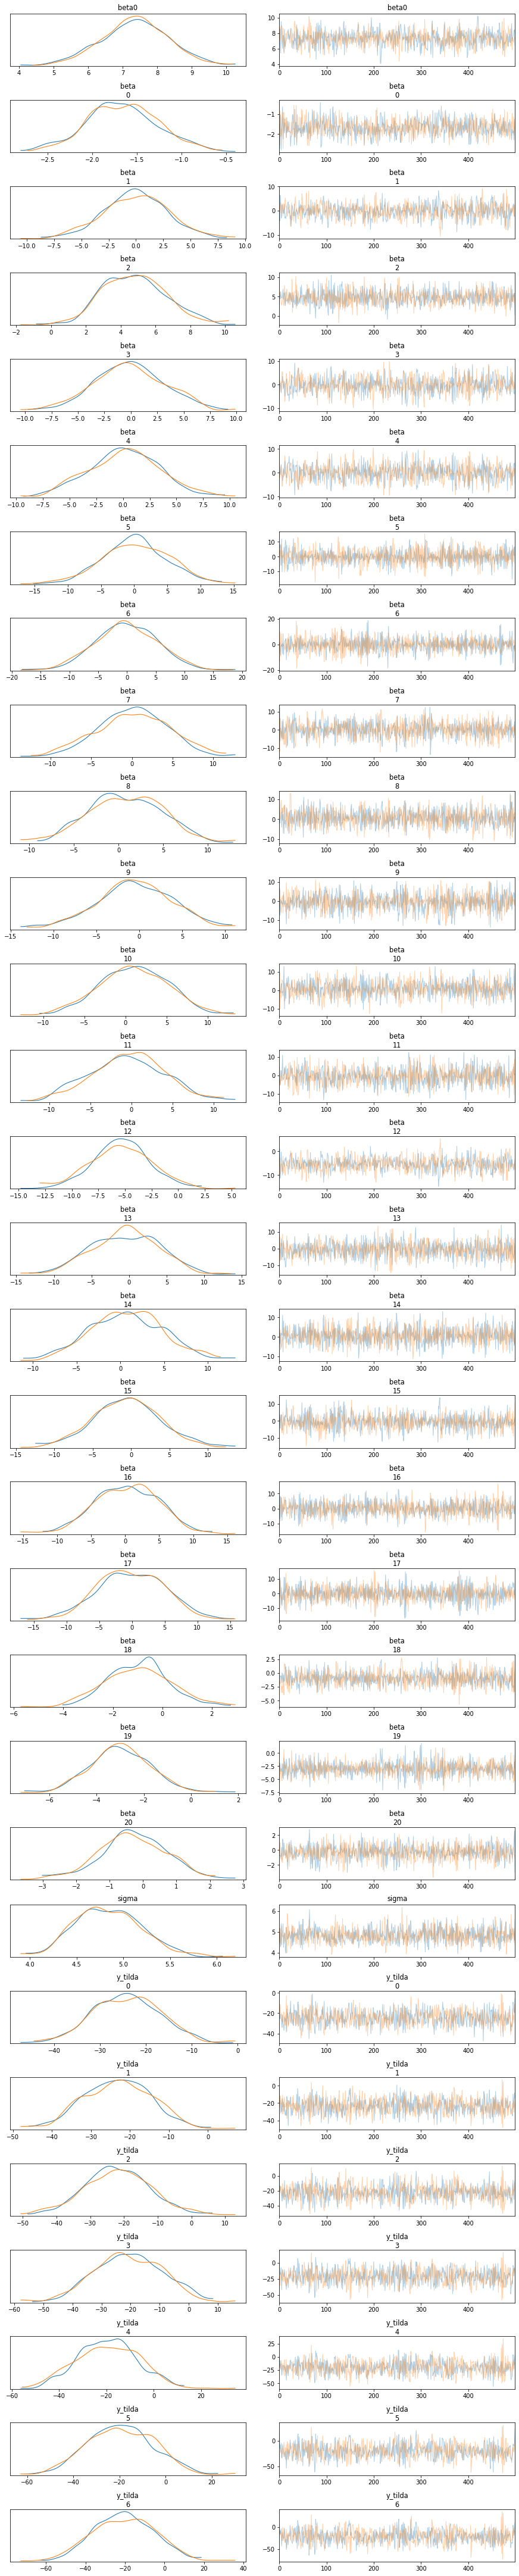

In [105]:
az.plot_trace(prediction2)

In [75]:
def summarize(model, coeff_name):
    summary = az.summary(model) 
    summary_coeff = summary.iloc[:len(coeff_name)]
    summary_coeff['policy'] = coeff_name
    
    return summary_coeff

def get_predictions(model, prediction_len):
    return model.get_posterior_mean()[-(prediction_len+1):-1].mean(axis=1)


In [76]:
coeff = ['intercept', 'STEMERG', 'CLSCHOOL', 'CLDAYCR', 'FM_ALL', 'FM_EMP', 'CLNURSHM',
       'EVICINTN', 'EVICENF', 'STAYHOME', 'END_STHM', 'CLBSNS', 'END_BSNS',
       'CLREST', 'ENDREST', 'CLGYM', 'ENDGYM', 'CLMOVIE', 'END_MOV',
         'sat', 'sun', 'new_confirmed_log']
summarize(prediction2, coeff)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,policy
beta0,7.340,0.988,5.386,9.138,0.034,0.024,852.0,832.0,849.0,744.0,1.00,intercept
beta[0],-1.662,0.405,-2.463,-0.902,0.012,0.009,1059.0,1021.0,1074.0,819.0,1.00,STEMERG
beta[1],-0.058,2.960,-5.966,5.416,0.099,0.096,887.0,479.0,891.0,639.0,1.00,CLSCHOOL
beta[2],4.768,1.832,1.759,8.456,0.049,0.035,1381.0,1372.0,1361.0,471.0,1.00,CLDAYCR
beta[3],-0.168,3.431,-6.419,6.424,0.112,0.109,934.0,495.0,934.0,707.0,1.00,FM_ALL
beta[4],0.110,3.429,-6.503,6.379,0.112,0.109,936.0,498.0,937.0,763.0,1.00,FM_EMP
beta[5],0.092,4.991,-8.366,10.141,0.117,0.186,1806.0,361.0,1803.0,665.0,1.01,CLNURSHM
beta[6],-0.157,5.479,-10.940,9.424,0.102,0.225,2879.0,297.0,2893.0,492.0,1.02,EVICINTN
beta[7],0.114,4.371,-8.402,8.131,0.107,0.151,1657.0,421.0,1539.0,736.0,1.01,EVICENF
beta[8],0.751,4.142,-6.176,8.844,0.104,0.131,1601.0,502.0,1582.0,750.0,1.00,STAYHOME


In [77]:
y_test = np.array(test['retail_and_recreation'])
y_pred = get_predictions(prediction2, 7)

In [78]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

1.962651960176779

In [79]:
# Ensemble
forecast = pd.read_csv('/Users/Jenny/Desktop/COVID19/cleaned/forecast.csv')
y_pred_ens = (np.array(forecast['retail'])+y_pred)/2
mean_squared_error(y_test, y_pred_ens, squared=False)

1.9588632588745811

In [ ]:
# Visualize

In [81]:
test_date = data.loc[data['a_state']=='IL', 'a_date'][-7:]
il = data[data['a_state']=='IL']
il.head()

,Unnamed: 0,a_state,a_date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,b_state,...,END_BSNS,CLREST,ENDREST,CLGYM,ENDGYM,CLMOVIE,END_MOV,weekno,sat,sun
1482,1483,IL,2020-02-15,4,3,10.0,3,3,-1,IL,...,0,0,0,0,0,0,0,5,1,0
1483,1484,IL,2020-02-16,8,2,29.0,3,2,-1,IL,...,0,0,0,0,0,0,0,6,0,1
1484,1485,IL,2020-02-17,2,-3,-14.0,-13,-23,6,IL,...,0,0,0,0,0,0,0,0,0,0
1485,1486,IL,2020-02-18,1,-1,5.0,2,1,0,IL,...,0,0,0,0,0,0,0,1,0,0
1486,1487,IL,2020-02-19,1,-1,3.0,2,1,0,IL,...,0,0,0,0,0,0,0,2,0,0


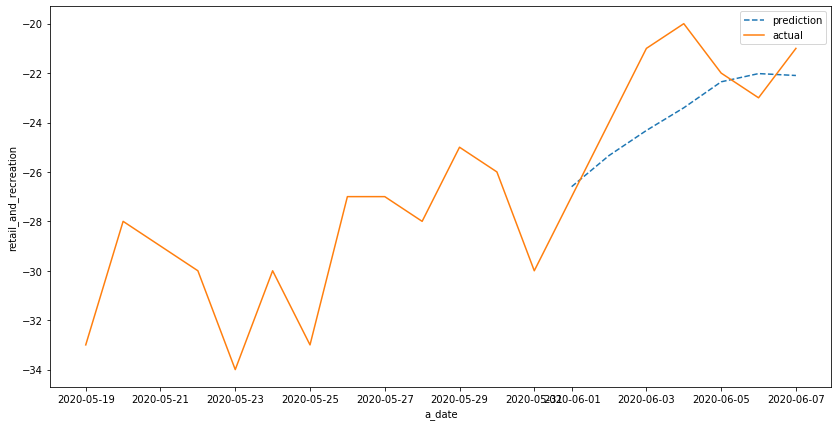

In [82]:
plt.subplots(figsize = (14,7))
ax = sns.lineplot(test_date, y_pred_ens, label='prediction')
ax.lines[0].set_linestyle("--")
sns.lineplot(il['a_date'][-20:], il['retail_and_recreation'][-20:], label='actual')

# Park

In [83]:
exog = onetime + pair_flattened+['confirmed_cases_state', 'sat', 'sun']
endog = ['parks']
model_df3 = model_data(data, X=exog, y=endog, state='IL')
model_df3 = new_confirmed_log_shifted(model_df3)
model_df3[onetime + pair_flattened] = model_df3[onetime + pair_flattened].cumsum()

train, test = train_test_split(model_df3, 7)

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
datalist = data_list(train, test, 'parks')
prediction3 = pystan.stan(model_code=modelscript2, data=datalist, 
                                         iter=1000, chains=2, control={'max_treedepth': 15}, seed=9)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f720581808657b0f4c6cdb28888475d2 NOW.


In [85]:
y_test = np.array(test['parks'])
y_pred = get_predictions(prediction3, 7)

In [86]:
mean_squared_error(y_test, y_pred, squared=False)

81.03341116029661

In [87]:
# Ensemble
y_pred_ens = (np.array(forecast['parks'])+y_pred)/2
mean_squared_error(y_test, y_pred_ens, squared=False)

44.25842322568984

In [107]:
y_test

array([ 24.,  45.,  35.,  53.,  59., 112., 138.])

In [106]:
y_pred

array([103.27848109, 116.60157187, 131.60005839, 143.37832354,
       158.17571385, 176.71961656, 193.03426006])

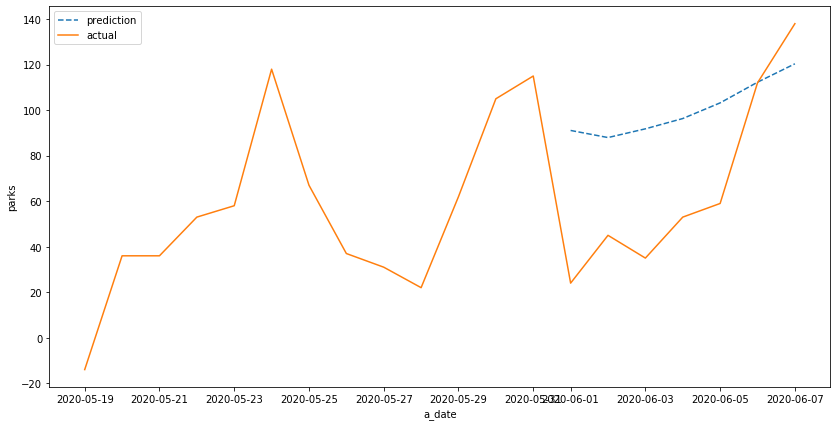

In [88]:
test_date = data.loc[data['a_state']=='IL', 'a_date'][-7:]
il = data[data['a_state']=='IL']

plt.subplots(figsize = (14,7))
ax = sns.lineplot(test_date, y_pred_ens, label='prediction')
ax.lines[0].set_linestyle("--")
sns.lineplot(il['a_date'][-20:], il['parks'][-20:], label='actual')

In [ ]:
modelscript2 = """
data {
    int<lower=0> N;
    int<lower=0> Nx;
    real y[N];
    matrix[N, Nx] x;
    int<lower=0> N_tilda;
    matrix[N_tilda, Nx] x_tilda;
}
parameters {
    real beta0;
    vector[Nx] beta;
    real<lower=0> sigma;
}
model {
    beta0 ~ cauchy(0,10);
    sigma ~ cauchy(0,5);
    
    for (i in 1:Nx)
        beta[i] ~ normal(0,5);
    
    y ~ normal(beta0 + x*beta, sigma);
}
generated quantities {
    real y_tilda[N_tilda] 
        = normal_rng(beta0 + x_tilda*beta, sigma);
}
"""

In [91]:
tmp = pystan.StanModel(model_code=modelscript2)
tmp_fit = tmp.sampling(data=datalist, iter=1000, chains=2, seed=9)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f720581808657b0f4c6cdb28888475d2 NOW.


In [101]:
import pickle
with open('/Users/Jenny/Desktop/COVID19/models/BayesModel_IL_Retail.pkl', 'wb') as f:
    pickle.dump(tmp, f, protocol=pickle.HIGHEST_PROTOCOL)

In [97]:
tmp_fit.extract()['y_tilda'].mean(axis=0)

array([103.39116137, 117.50279391, 132.45233528, 145.66598508,
       159.88320209, 176.91794881, 199.04245913])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22d3b400>,
      dtype=object)

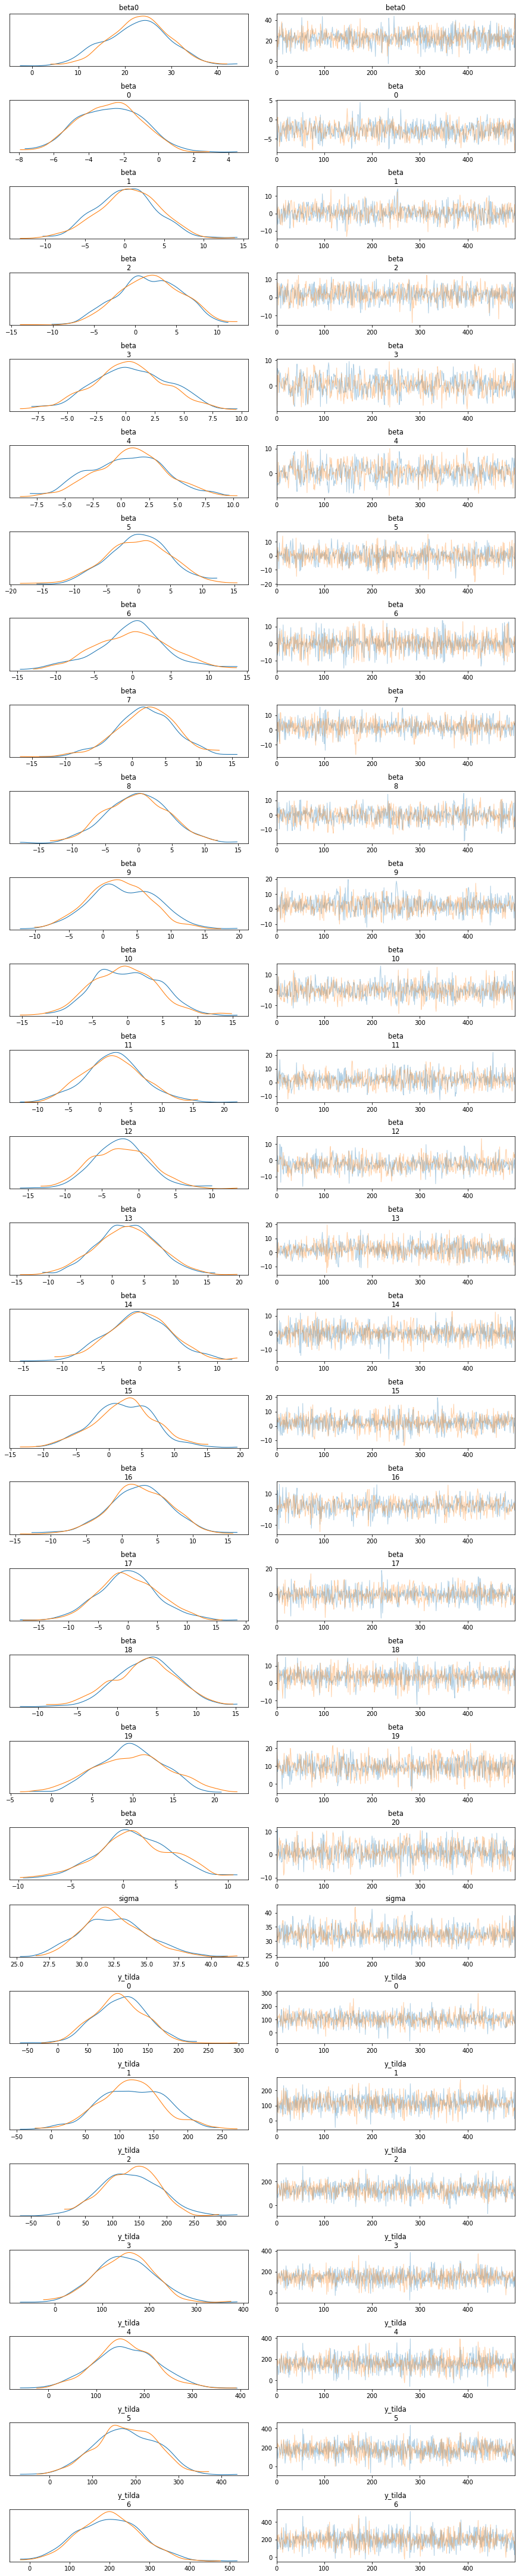

In [104]:
az.plot_trace(tmp_fit)

In [ ]:
prediction3 = pystan.stan(model_code=modelscript2, data=datalist, 
                                         iter=1000, chains=2, control={'max_treedepth': 15}, seed=9)